<a href="https://colab.research.google.com/github/Danieljoshua720/Electricity-demand-forecasting-AIML/blob/main/1_year_prediction_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam


In [2]:
df=pd.read_csv('/content/powerdemand_5min_2021_to_2024_with weather.csv')

In [3]:
df.head()

,Unnamed: 0,datetime,Power demand,temp,dwpt,rhum,wdir,wspd,pres,year,month,day,hour,minute,moving_avg_3
0,0,2021-01-01 00:30:00,2014.00,8.0,6.9,93.0,0.0,0.0,1017.0,2021,1,1,0,30,NaN
1,1,2021-01-01 00:35:00,2005.63,8.0,6.9,93.0,0.0,0.0,1017.0,2021,1,1,0,35,NaN
2,2,2021-01-01 00:40:00,1977.60,8.0,6.9,93.0,0.0,0.0,1017.0,2021,1,1,0,40,1999.076667
3,3,2021-01-01 00:45:00,1976.44,8.0,6.9,93.0,0.0,0.0,1017.0,2021,1,1,0,45,1986.556667
4,4,2021-01-01 00:50:00,1954.37,8.0,6.9,93.0,0.0,0.0,1017.0,2021,1,1,0,50,1969.470000


In [4]:
df.tail()

,Unnamed: 0,datetime,Power demand,temp,dwpt,rhum,wdir,wspd,pres,year,month,day,hour,minute,moving_avg_3
393435,393435,2024-12-12 00:10:00,2146.84,12.3,6.8,69.0,269.0,1.8,1019.4,2024,12,12,0,10,2174.893333
393436,393436,2024-12-12 00:15:00,2116.66,12.3,6.8,69.0,269.0,1.8,1019.4,2024,12,12,0,15,2139.416667
393437,393437,2024-12-12 00:20:00,2082.77,12.3,6.8,69.0,269.0,1.8,1019.4,2024,12,12,0,20,2115.423333
393438,393438,2024-12-12 00:25:00,2059.17,12.3,6.8,69.0,269.0,1.8,1019.4,2024,12,12,0,25,2086.200000
393439,393439,2024-12-12 00:30:00,2049.66,12.3,6.8,69.0,269.0,1.8,1019.4,2024,12,12,0,30,2063.866667


In [5]:


# Detect correct time column
if 'datetime' in df.columns:
    time_col = 'datetime'
elif 'time' in df.columns:
    time_col = 'time'
else:
    raise ValueError("No datetime column found")

df[time_col] = pd.to_datetime(df[time_col], errors='coerce')
df = df.dropna(subset=[time_col])
df = df.sort_values(time_col).reset_index(drop=True)

target_col = 'Power demand'


In [6]:
train_df = df[
    (df[time_col] >= '2023-01-01') &
    (df[time_col] <= '2023-12-31')
]

test_df = df[
    (df[time_col] >= '2024-01-01') &
    (df[time_col] <= '2024-12-31')
]

print("Train 2023 rows:", len(train_df))
print("Test 2024 rows :", len(test_df))


Train 2023 rows: 102075
Test 2024 rows : 94265


In [7]:
scaler = MinMaxScaler()

train_scaled = scaler.fit_transform(train_df[[target_col]])
test_scaled  = scaler.transform(test_df[[target_col]])


In [8]:
def create_sequences(data, n_past):
    X, y = [], []
    for i in range(n_past, len(data)):
        X.append(data[i-n_past:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

n_past = 24 * 7   # 1 week history (change if needed)

X_train, y_train = create_sequences(train_scaled, n_past)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)


In [9]:
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(n_past, 1)),
    Dropout(0.2),
    LSTM(64),
    Dense(1)
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mse'
)

model.fit(
    X_train,
    y_train,
    epochs=20,
    batch_size=64,
    verbose=1
)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
1593/1593 ━━━━━━━━━━━━━━━━━━━━ 758s 474ms/step - loss: 0.0034
Epoch 2/20
1593/1593 ━━━━━━━━━━━━━━━━━━━━ 754s 473ms/step - loss: 2.8424e-04
Epoch 3/20
1593/1593 ━━━━━━━━━━━━━━━━━━━━ 746s 469ms/step - loss: 1.9773e-04
Epoch 4/20
1593/1593 ━━━━━━━━━━━━━━━━━━━━ 747s 468ms/step - loss: 1.6982e-04
Epoch 5/20
1593/1593 ━━━━━━━━━━━━━━━━━━━━ 749s 470ms/step - loss: 1.4630e-04
Epoch 6/20
1593/1593 ━━━━━━━━━━━━━━━━━━━━ 739s 464ms/step - loss: 1.3492e-04
Epoch 7/20
1593/1593 ━━━━━━━━━━━━━━━━━━━━ 739s 464ms/step - loss: 1.6110e-04
Epoch 8/20
1593/1593 ━━━━━━━━━━━━━━━━━━━━ 738s 464ms/step - loss: 1.4595e-04
Epoch 9/20
1593/1593 ━━━━━━━━━━━━━━━━━━━━ 745s 465ms/step - loss: 1.7671e-04
Epoch 10/20
1593/1593 ━━━━━━━━━━━━━━━━━━━━ 745s 468ms/step - loss: 1.5265e-04
Epoch 11/20
1593/1593 ━━━━━━━━━━━━━━━━━━━━ 731s 459ms/step - loss: 1.4228e-04
Epoch 12/20
1593/1593 ━━━━━━━━━━━━━━━━━━━━ 727s 456ms/step - loss: 1.9634e-04
Epoch 13/20
1593/1593 ━━━━━━━━━━━━━━━━━━━━ 738s 463ms/step - loss: 1.5759e-04

In [10]:
model.save("lstm_power_model.h5")


In [11]:
history = train_scaled.tolist()   # start with full 2023
predictions = []

for i in range(len(test_scaled)):
    x_input = np.array(history[-n_past:])
    x_input = x_input.reshape(1, n_past, 1)

    y_pred = model.predict(x_input, verbose=0)
    predictions.append(y_pred[0, 0])

    # append ACTUAL value (realistic forecasting)
    history.append([test_scaled[i, 0]])


In [12]:
predictions = scaler.inverse_transform(
    np.array(predictions).reshape(-1, 1)
)

actual_2023 = train_df[target_col].values.reshape(-1, 1)


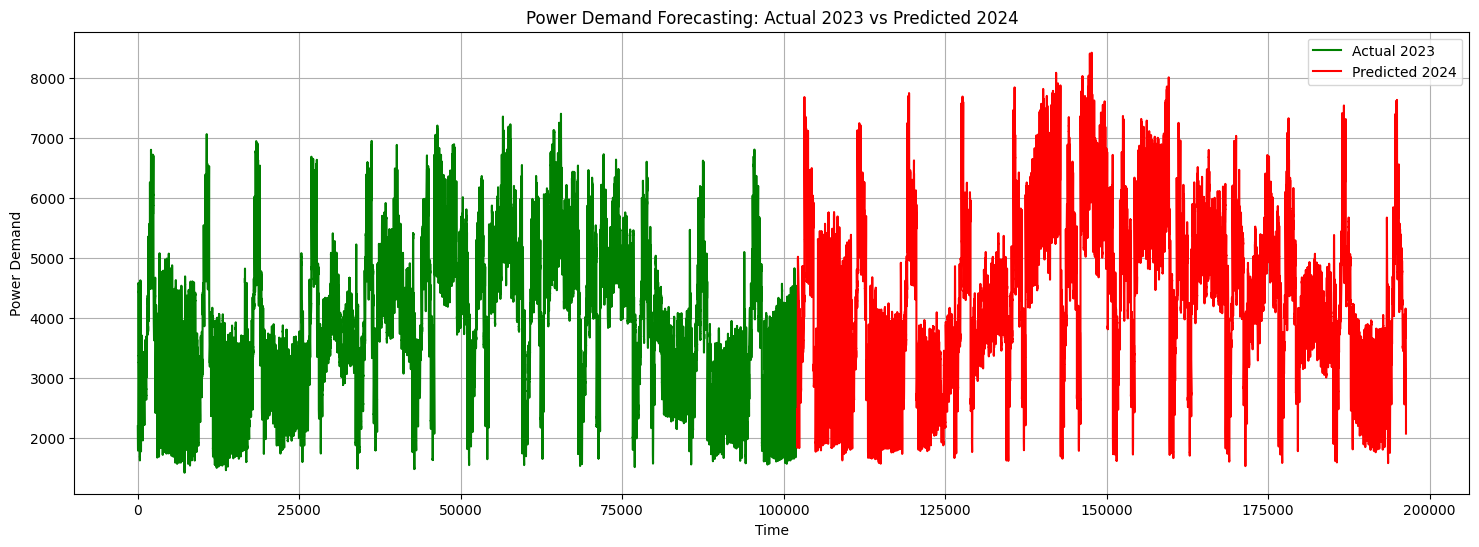

In [13]:
plt.figure(figsize=(18, 6))

plt.plot(
    actual_2023,
    label='Actual 2023',
    color='green'
)

plt.plot(
    range(len(actual_2023), len(actual_2023) + len(predictions)),
    predictions,
    label='Predicted 2024',
    color='red'
)

plt.title('Power Demand Forecasting: Actual 2023 vs Predicted 2024')
plt.xlabel('Time')
plt.ylabel('Power Demand')
plt.legend()
plt.grid(True)
plt.show()


In [14]:
print(len(actual_2023))
print(len(predictions))
print(len(test_df))


102075
94265
94265


In [15]:
import pandas as pd
import numpy as np

df_plot = pd.DataFrame({
    "datetime": test_df[time_col].iloc[:len(predictions)].values,
    "Predicted_2024": predictions.flatten(),
    "Actual_2023": actual_2023[-len(predictions):].flatten()
})


In [16]:
df_plot["datetime"] = pd.to_datetime(df_plot["datetime"])
df_plot["month"] = df_plot["datetime"].dt.month


In [17]:
import matplotlib.pyplot as plt

def plot_monthwise(month_num, month_name):
    df_m = df_plot[df_plot["month"] == month_num]

    plt.figure(figsize=(18, 6))

    plt.plot(
        df_m["Actual_2023"].values,
        label="Actual 2023",
        color="green"
    )

    plt.plot(
        range(len(df_m["Actual_2023"]),
              len(df_m["Actual_2023"]) + len(df_m["Predicted_2024"])),
        df_m["Predicted_2024"].values,
        label="Predicted 2024",
        color="red"
    )

    plt.title(f"{month_name} 2024: Actual vs Predicted Power Demand")
    plt.xlabel("Time")
    plt.ylabel("Power Demand")
    plt.legend()
    plt.grid(True)
    plt.show()


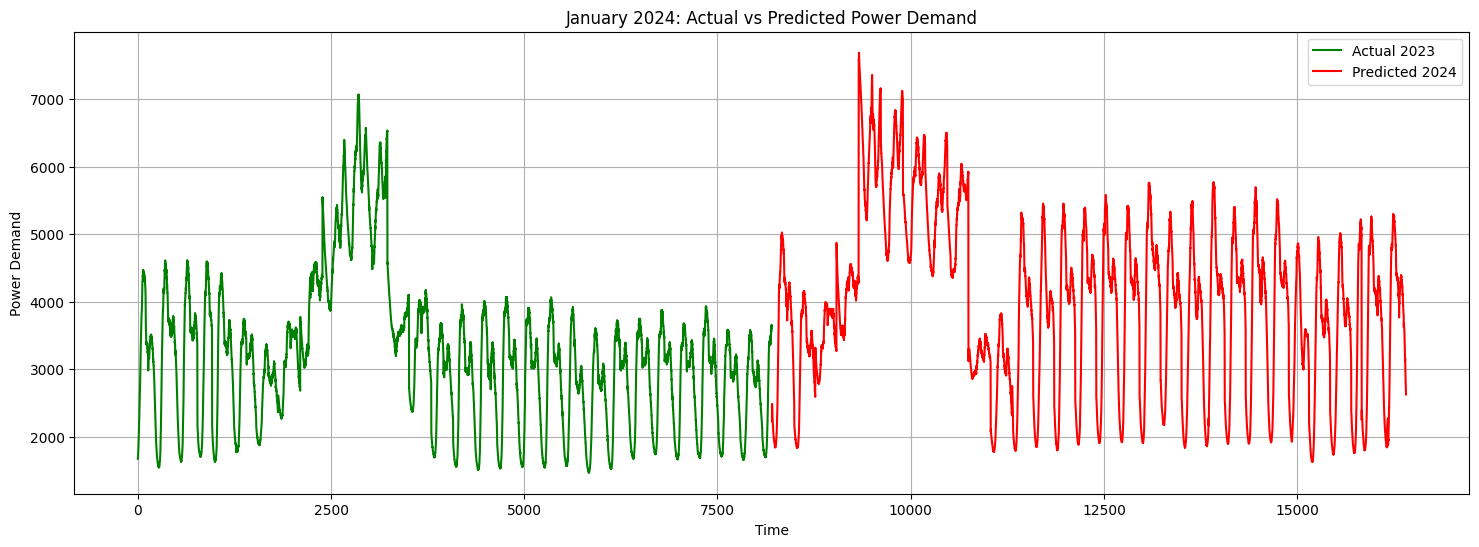

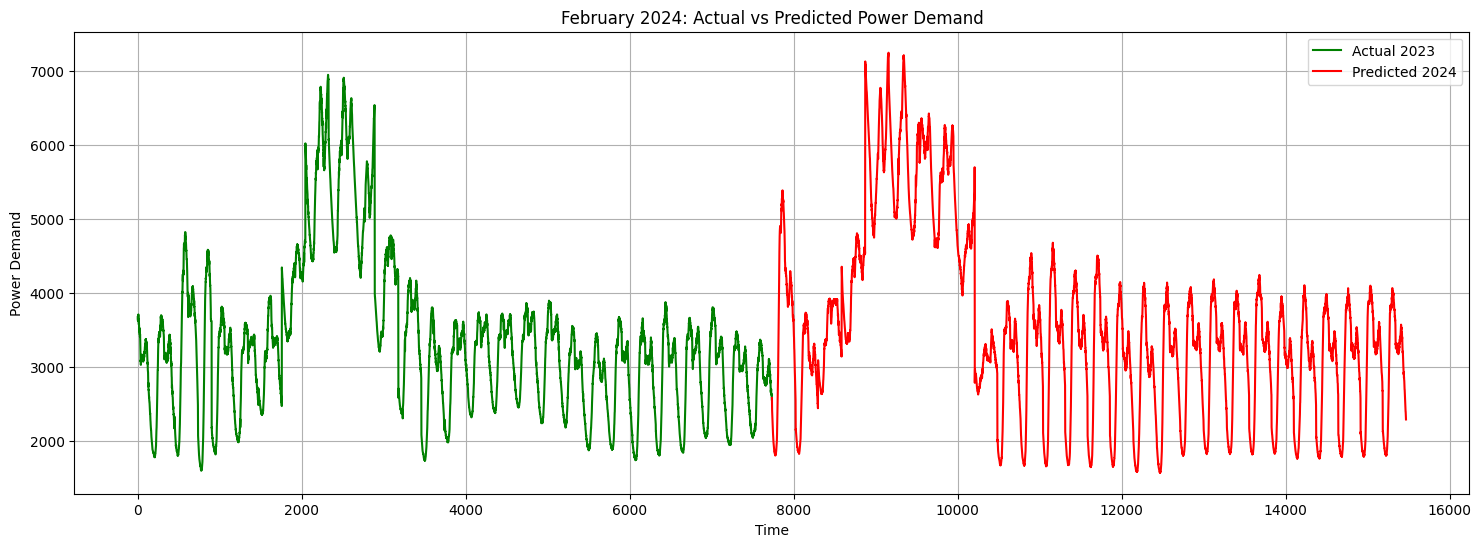

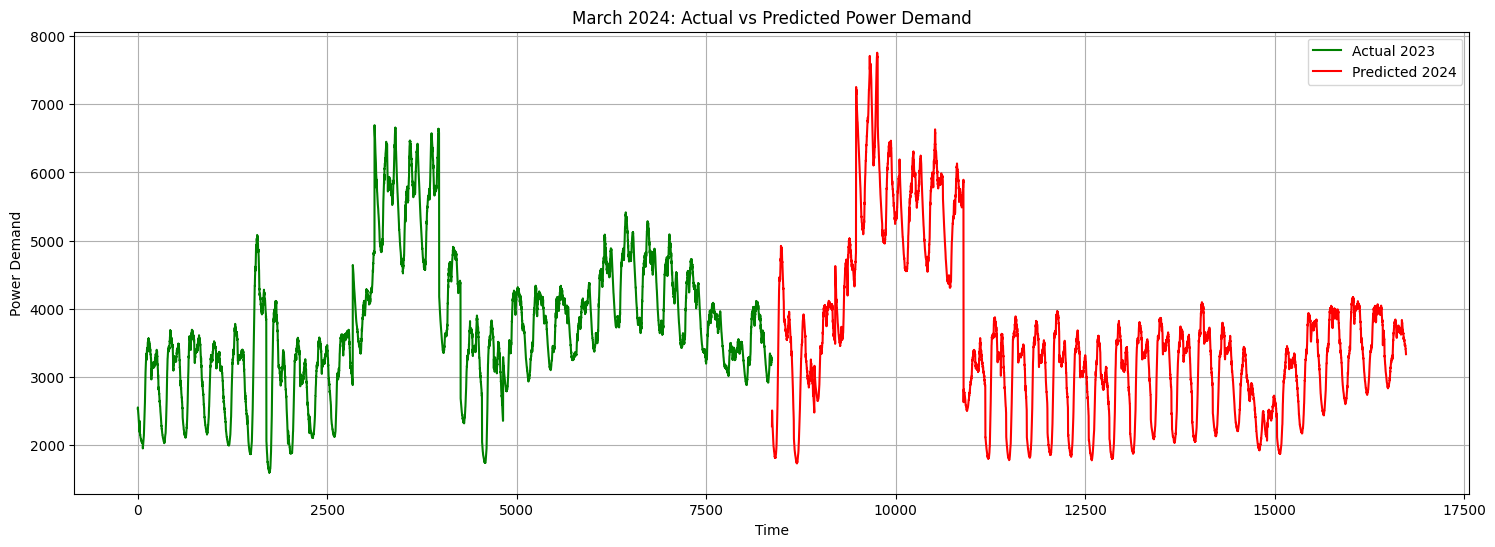

In [18]:
plot_monthwise(1, "January")
plot_monthwise(2, "February")
plot_monthwise(3, "March")


In [20]:

actual_2024= df[
    (df[time_col] >= '2024-01-01') &
    (df[time_col] <= '2024-12-31')
]


print("ATUAL  2024 rows :", len(actual_2024))


ATUAL  2024 rows : 94265


In [24]:
print(len(actual_2024), len(predictions))


94265 94265


In [28]:
import pandas as pd

# Assuming your data starts on 2024-01-01 00:00:00 and has 5-minute intervals
datetime_list = pd.date_range(start='2024-01-01', periods=len(actual_2024), freq='5T')


/tmp/ipython-input-1386194549.py:4: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  datetime_list = pd.date_range(start='2024-01-01', periods=len(actual_2024), freq='5T')


/tmp/ipython-input-90270822.py:8: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  datetime_list = pd.date_range(start='2024-01-01', periods=len(actual_flat), freq='5T')


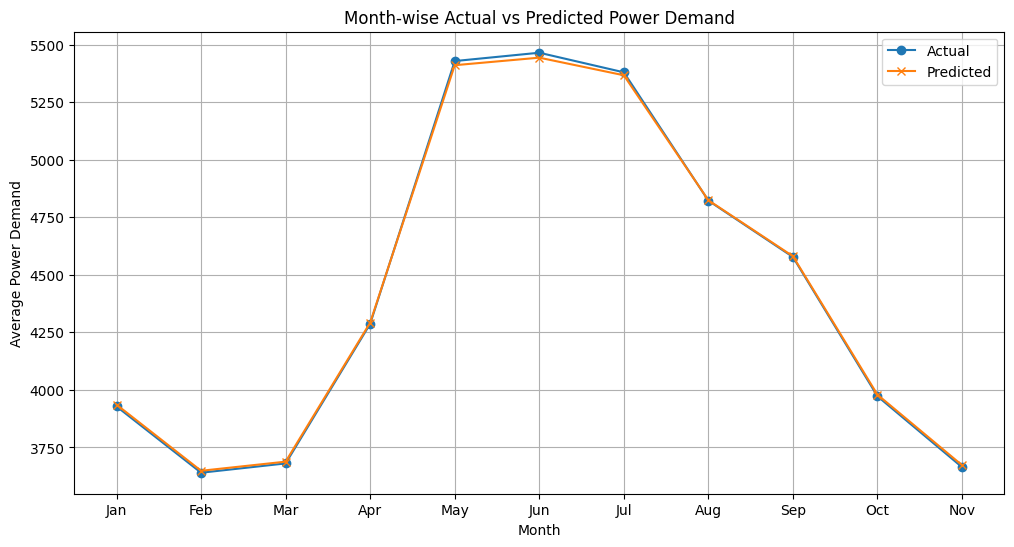

In [30]:
import pandas as pd

# Flatten arrays if they are 2D
actual_flat = actual_2024.flatten() if hasattr(actual_2024, "shape") and len(actual_2024.shape) > 1 else actual_2024
pred_flat = predictions.flatten() if hasattr(predictions, "shape") and len(predictions.shape) > 1 else predictions

# Create datetime list for 5-min intervals
datetime_list = pd.date_range(start='2024-01-01', periods=len(actual_flat), freq='5T')

# Create DataFrame
df = pd.DataFrame({
    'datetime': datetime_list,
    'actual': actual_flat,
    'predicted': pred_flat
})

# Aggregate by month
df['month'] = df['datetime'].dt.month
monthly = df.groupby('month')[['actual','predicted']].mean()

# Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(monthly.index, monthly['actual'], marker='o', label='Actual')
plt.plot(monthly.index, monthly['predicted'], marker='x', label='Predicted')
plt.xticks(monthly.index, [pd.Timestamp(2024,m,1).strftime('%b') for m in monthly.index])
plt.xlabel('Month')
plt.ylabel('Average Power Demand')
plt.title('Month-wise Actual vs Predicted Power Demand')
plt.legend()
plt.grid(True)
plt.show()


In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Flatten (important)
actual_flat = actual_2024.flatten()
pred_flat   = predictions.flatten()

# Datetime (5-min resolution)
datetime_list = pd.date_range(
    start='2024-01-01',
    periods=len(actual_flat),
    freq='5min'
)

# DataFrame
df = pd.DataFrame({
    'datetime': datetime_list,
    'actual': actual_flat,
    'predicted': pred_flat
})

df['month'] = df['datetime'].dt.month


/tmp/ipython-input-2674234046.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  monthly_error = df.groupby('month').apply(


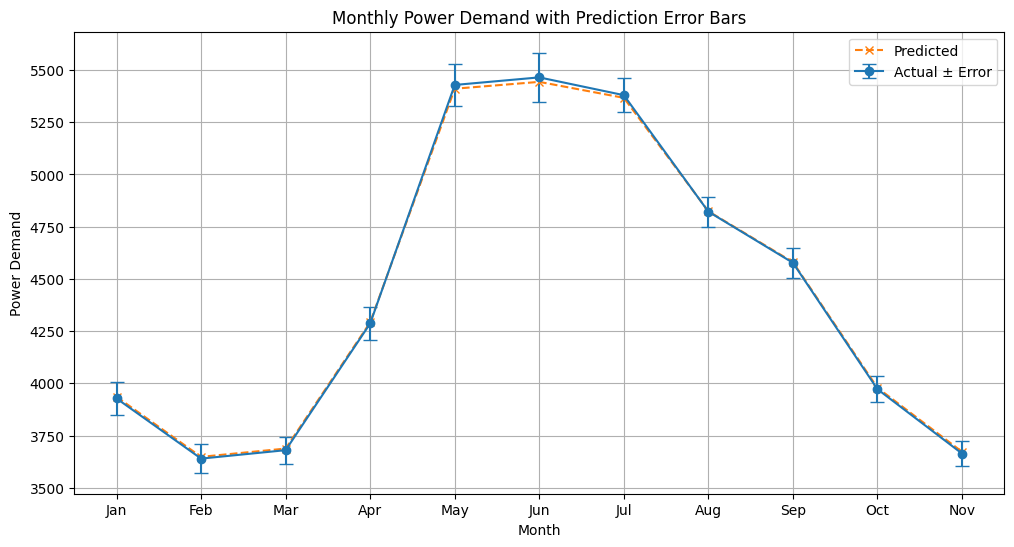

In [33]:
# Monthly error statistics
monthly_error = df.groupby('month').apply(
    lambda x: x['actual'] - x['predicted']
)

monthly_std = monthly_error.groupby('month').std()
monthly_mean = df.groupby('month')[['actual','predicted']].mean()

# Plot with error bars
plt.figure(figsize=(12,6))

plt.errorbar(
    monthly_mean.index,
    monthly_mean['actual'],
    yerr=monthly_std,
    fmt='o-',
    capsize=5,
    label='Actual ± Error'
)

plt.plot(
    monthly_mean.index,
    monthly_mean['predicted'],
    'x--',
    label='Predicted'
)

plt.xticks(
    monthly_mean.index,
    [pd.Timestamp(2024,m,1).strftime('%b') for m in monthly_mean.index]
)

plt.xlabel('Month')
plt.ylabel('Power Demand')
plt.title('Monthly Power Demand with Prediction Error Bars')
plt.legend()
plt.grid(True)
plt.show()


In [35]:
monthly_metrics = []

for m in sorted(df['month'].unique()):
    temp = df[df['month'] == m]

    mae = mean_absolute_error(temp['actual'], temp['predicted'])
    rmse = np.sqrt(mean_squared_error(temp['actual'], temp['predicted']))

    monthly_metrics.append([m, mae, rmse])

metrics_df = pd.DataFrame(
    monthly_metrics,
    columns=['Month','MAE','RMSE']
)

metrics_df['Month'] = metrics_df['Month'].apply(
    lambda m: pd.Timestamp(2024,m,1).strftime('%b')
)

metrics_df


,Month,MAE,RMSE
0,Jan,34.305721,80.157039
1,Feb,31.217486,68.055522
2,Mar,29.456426,64.727875
3,Apr,30.030474,80.947065
4,May,44.120909,101.772428
5,Jun,47.415630,119.928907
6,Jul,37.714776,80.941275
7,Aug,29.428037,71.890260
8,Sep,30.172098,71.640265
9,Oct,30.303208,62.182937


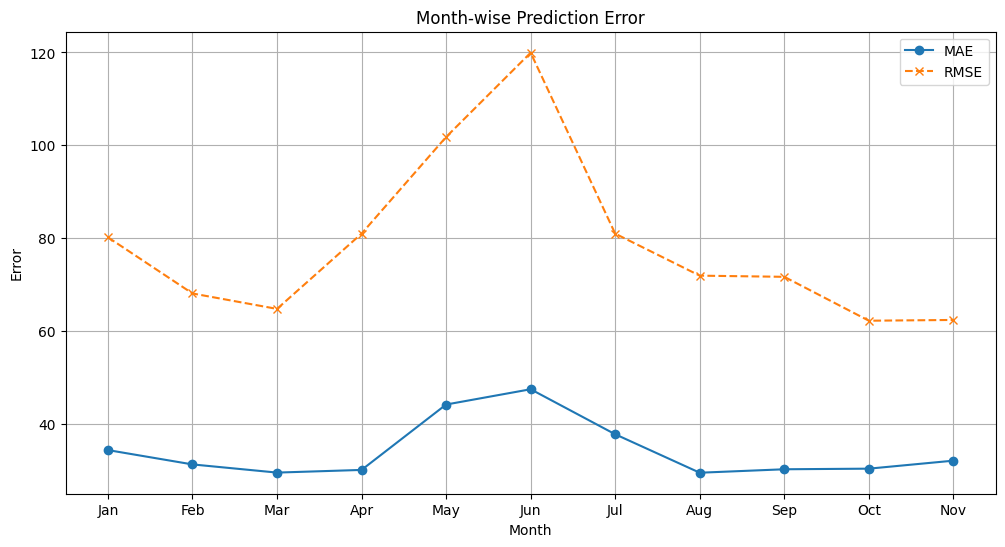

In [36]:
plt.figure(figsize=(12,6))

plt.plot(metrics_df['Month'], metrics_df['MAE'], 'o-', label='MAE')
plt.plot(metrics_df['Month'], metrics_df['RMSE'], 'x--', label='RMSE')

plt.xlabel('Month')
plt.ylabel('Error')
plt.title('Month-wise Prediction Error')
plt.legend()
plt.grid(True)
plt.show()


In [38]:
from sklearn.metrics import r2_score
import numpy as np

y_true = np.array(actual_2024).reshape(-1)
y_pred = np.array(predictions).reshape(-1)


In [39]:
r2 = r2_score(y_true, y_pred)
print(f"Overall R² score: {r2:.4f}")


Overall R² score: 0.9967


In [40]:
df['actual'] = y_true
df['predicted'] = y_pred

monthly_r2 = df.groupby('month').apply(
    lambda x: r2_score(x['actual'], x['predicted'])
).reset_index(name='R2')

monthly_r2


/tmp/ipython-input-4115759634.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  monthly_r2 = df.groupby('month').apply(


,month,R2
0,1,0.996086
1,2,0.997219
2,3,0.997394
3,4,0.992500
4,5,0.994818
5,6,0.993411
6,7,0.996054
7,8,0.995006
8,9,0.995059
9,10,0.996025


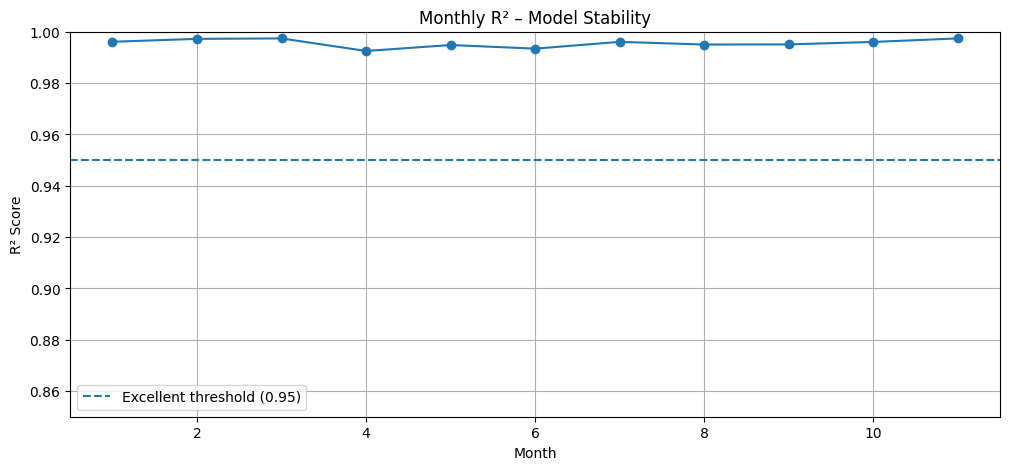

In [41]:
plt.figure(figsize=(12,5))
plt.plot(monthly_r2['month'], monthly_r2['R2'], marker='o')

plt.axhline(0.95, linestyle='--', label='Excellent threshold (0.95)')
plt.ylim(0.85, 1.0)

plt.xlabel('Month')
plt.ylabel('R² Score')
plt.title('Monthly R² – Model Stability')
plt.legend()
plt.grid(True)
plt.show()


In [44]:
import pandas as pd
import numpy as np

df = pd.DataFrame({
    "datetime": test_df[time_col].iloc[:len(predictions)].values,
    "actual": actual_2024[:len(predictions)].reshape(-1),
    "predicted": predictions.reshape(-1)
})

df["datetime"] = pd.to_datetime(df["datetime"])
df["month"] = df["datetime"].dt.month
df["month_name"] = df["datetime"].dt.strftime('%b')


In [54]:
df["month"] = df["datetime"].dt.month
df["month_name"] = df["datetime"].dt.month_name().str[:3]


In [55]:
monthly_pred = (
    df.groupby(["month", "month_name"])
      .agg(
          Actual_Mean=("actual", "mean"),
          Predicted_Mean=("predicted", "mean")
      )
      .reset_index()
      .sort_values("month")
)

monthly_pred


,month,month_name,Actual_Mean,Predicted_Mean
0,1,Jan,3987.341881,3994.791260
1,2,Feb,3541.571346,3551.843262
2,3,Mar,3557.993154,3566.630615
3,4,Apr,4223.679707,4228.664551
4,5,May,5543.257322,5522.388184
5,6,Jun,5590.680214,5567.757812
6,7,Jul,5377.002144,5363.595703
7,8,Aug,4878.867412,4879.898926
8,9,Sep,4620.071606,4623.562988
9,10,Oct,4138.028898,4144.585938


In [56]:
from sklearn.metrics import r2_score
import numpy as np

r2_monthly = []

for m in sorted(df["month"].unique()):
    mdf = df[df["month"] == m]

    r2_monthly.append({
        "Month": mdf["month_name"].iloc[0],
        "R2": r2_score(mdf["actual"], mdf["predicted"])
    })

pd.DataFrame(r2_monthly)


,Month,R2
0,Jan,0.995918
1,Feb,0.997475
2,Mar,0.997459
3,Apr,0.993961
4,May,0.995485
5,Jun,0.992621
6,Jul,0.995267
7,Aug,0.994343
8,Sep,0.994365
9,Oct,0.993883


In [57]:
import numpy as np
from sklearn.metrics import r2_score

monthly_stats = []

for m in sorted(df["month"].unique()):
    mdf = df[df["month"] == m]

    errors = mdf["actual"] - mdf["predicted"]

    monthly_stats.append({
        "Month": mdf["month_name"].iloc[0],
        "Actual_Mean": mdf["actual"].mean(),
        "Predicted_Mean": mdf["predicted"].mean(),
        "Error_STD": errors.std(),
        "R2": r2_score(mdf["actual"], mdf["predicted"])
    })

monthly_stats_df = pd.DataFrame(monthly_stats)
monthly_stats_df


,Month,Actual_Mean,Predicted_Mean,Error_STD,R2
0,Jan,3987.341881,3994.791260,82.255228,0.995918
1,Feb,3541.571346,3551.843262,61.179408,0.997475
2,Mar,3557.993154,3566.630615,59.894336,0.997459
3,Apr,4223.679707,4228.665039,71.319434,0.993961
4,May,5543.257322,5522.388184,90.468741,0.995485
5,Jun,5590.680214,5567.757812,119.430933,0.992621
6,Jul,5377.002144,5363.595215,89.684953,0.995267
7,Aug,4878.867412,4879.898926,76.316795,0.994343
8,Sep,4620.071606,4623.563477,75.425966,0.994365
9,Oct,4138.028898,4144.585938,69.918540,0.993883


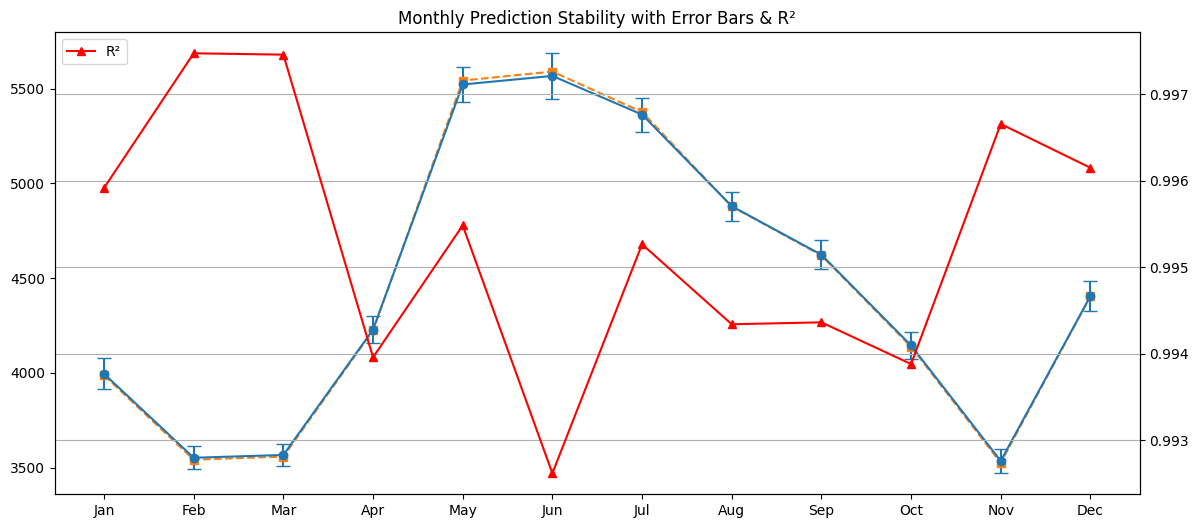

In [58]:
plt.figure(figsize=(14,6))

plt.errorbar(
    monthly_stats_df["Month"],
    monthly_stats_df["Predicted_Mean"],
    yerr=monthly_stats_df["Error_STD"],
    fmt='o-', capsize=5,
    label="Predicted (±1σ)"
)

plt.plot(
    monthly_stats_df["Month"],
    monthly_stats_df["Actual_Mean"],
    's--', label="Actual Mean"
)

plt.twinx()
plt.plot(
    monthly_stats_df["Month"],
    monthly_stats_df["R2"],
    'r^-', label="R²"
)

plt.title("Monthly Prediction Stability with Error Bars & R²")
plt.grid(True)
plt.legend(loc="upper left")
plt.show()


In [59]:
june_peak = df[
    (df["month"] == 6) &
    (df["datetime"].dt.hour >= 17) &
    (df["datetime"].dt.hour <= 21)
]


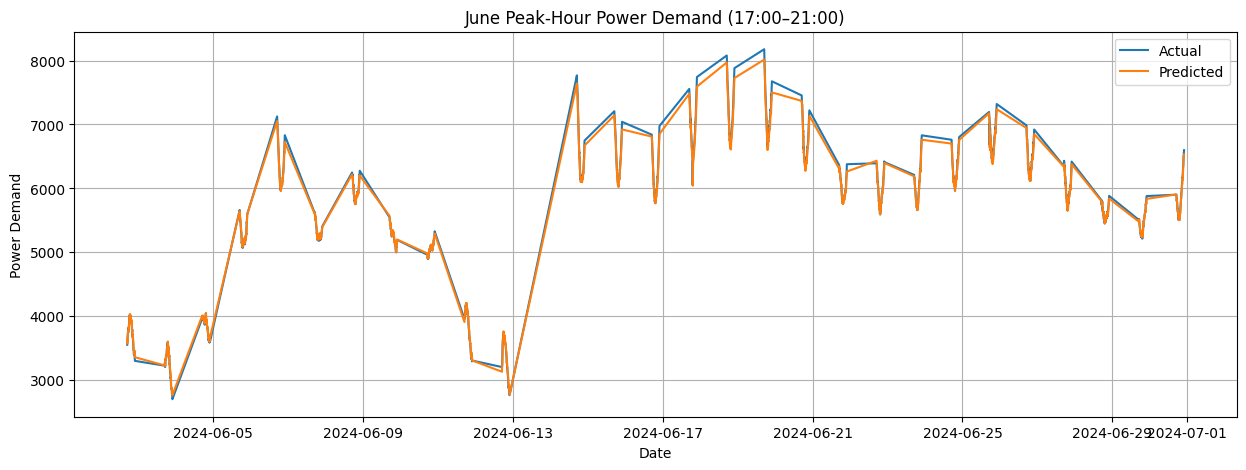

In [60]:
plt.figure(figsize=(15,5))

plt.plot(
    june_peak["datetime"],
    june_peak["actual"],
    label="Actual",
    linewidth=1.5
)

plt.plot(
    june_peak["datetime"],
    june_peak["predicted"],
    label="Predicted",
    linewidth=1.5
)

plt.title("June Peak-Hour Power Demand (17:00–21:00)")
plt.xlabel("Date")
plt.ylabel("Power Demand")
plt.legend()
plt.grid(True)
plt.show()


In [61]:
df = pd.DataFrame({
    "datetime": pd.to_datetime(datetime_list),
    "actual": actual_2024.reshape(-1),
    "predicted": predictions.reshape(-1)
})

# Sort by time (important for correct plot)
df = df.sort_values("datetime").reset_index(drop=True)


In [62]:
df.head()


,datetime,actual,predicted
0,2024-01-01 00:00:00,2535.71,2227.130615
1,2024-01-01 00:05:00,2473.16,2483.872314
2,2024-01-01 00:10:00,2456.83,2483.010742
3,2024-01-01 00:15:00,2410.87,2478.345947
4,2024-01-01 00:20:00,2378.55,2427.974854


In [64]:
df["month"] = df["datetime"].dt.month
df["month_name"] = df["datetime"].dt.strftime("%b")

monthly_avg = df.groupby("month_name")[["actual", "predicted"]].mean()
monthly_avg = monthly_avg.reindex(
    ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]
)


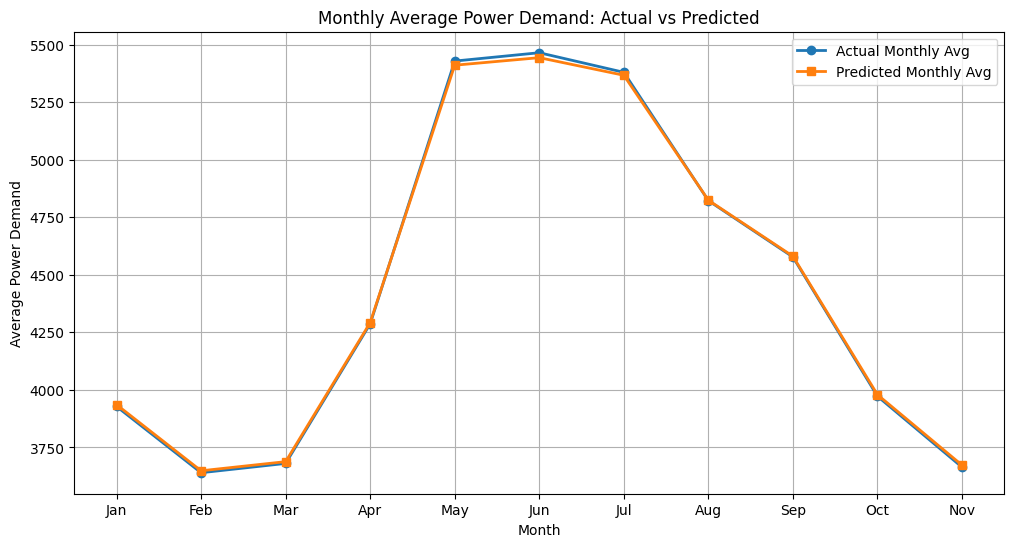

In [65]:
plt.figure(figsize=(12,6))

plt.plot(
    monthly_avg.index,
    monthly_avg["actual"],
    marker="o",
    linewidth=2,
    label="Actual Monthly Avg"
)

plt.plot(
    monthly_avg.index,
    monthly_avg["predicted"],
    marker="s",
    linewidth=2,
    label="Predicted Monthly Avg"
)

plt.title("Monthly Average Power Demand: Actual vs Predicted")
plt.xlabel("Month")
plt.ylabel("Average Power Demand")
plt.legend()
plt.grid(True)
plt.show()


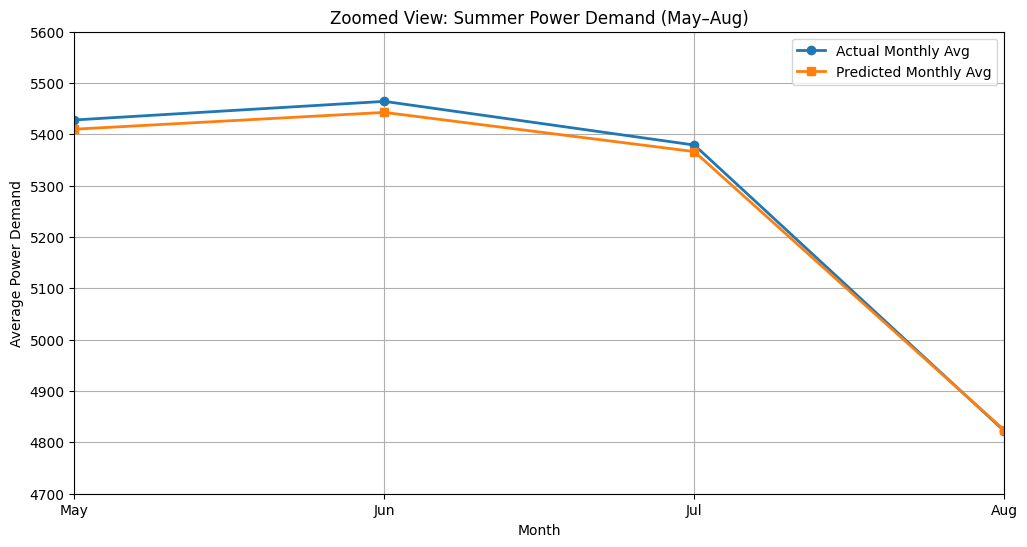

In [75]:
plt.figure(figsize=(12,6))

plt.plot(
    monthly_avg.index,
    monthly_avg["actual"],
    marker="o",
    linewidth=2,
    label="Actual Monthly Avg"
)

plt.plot(
    monthly_avg.index,
    monthly_avg["predicted"],
    marker="s",
    linewidth=2,
    label="Predicted Monthly Avg"
)

# 🔎 ZOOM HERE
plt.xlim("May", "Aug")
plt.ylim(4700, 5600)

plt.title("Zoomed View: Summer Power Demand (May–Aug)")
plt.xlabel("Month")
plt.ylabel("Average Power Demand")
plt.legend()
plt.grid(True)
plt.show()


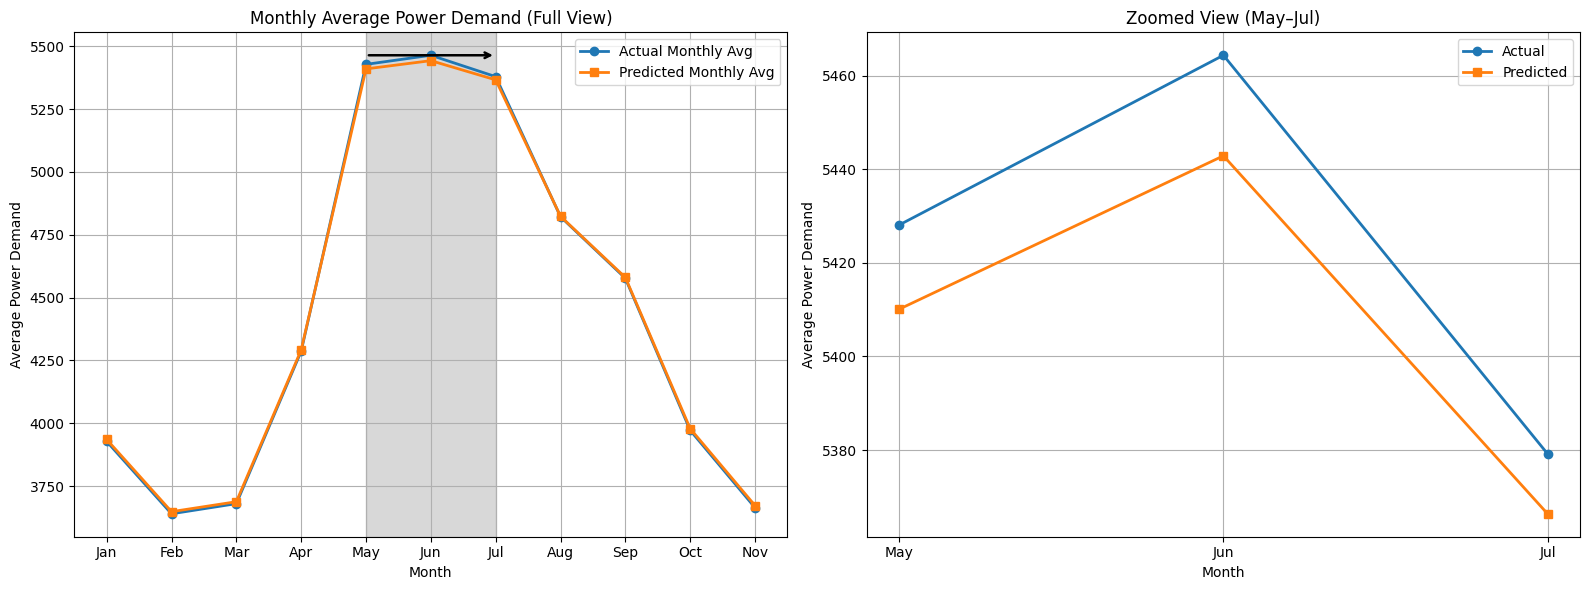

In [76]:
import matplotlib.pyplot as plt

# ===============================
# USER SETTINGS (CHANGE IF NEEDED)
# ===============================
zoom_start = "May"   # start month for zoom
zoom_end   = "Jul"   # end month for zoom

# monthly_avg must already exist with:
# monthly_avg.index -> Month names (Jan, Feb, ...)
# monthly_avg["actual"]
# monthly_avg["predicted"]

# ===============================
# CREATE FIGURE
# ===============================
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# ===============================
# LEFT PLOT: FULL MONTHLY VIEW
# ===============================
axes[0].plot(
    monthly_avg.index,
    monthly_avg["actual"],
    marker="o",
    linewidth=2,
    label="Actual Monthly Avg"
)

axes[0].plot(
    monthly_avg.index,
    monthly_avg["predicted"],
    marker="s",
    linewidth=2,
    label="Predicted Monthly Avg"
)

# Highlight zoom region
axes[0].axvspan(zoom_start, zoom_end, color="gray", alpha=0.3)

axes[0].set_title("Monthly Average Power Demand (Full View)")
axes[0].set_xlabel("Month")
axes[0].set_ylabel("Average Power Demand")
axes[0].legend()
axes[0].grid(True)

# Arrow indicator
axes[0].annotate(
    "",
    xy=(zoom_end, monthly_avg["actual"].max()),
    xytext=(zoom_start, monthly_avg["actual"].max()),
    arrowprops=dict(arrowstyle="->", lw=1.8)
)

# ===============================
# RIGHT PLOT: ZOOMED VIEW
# ===============================
zoomed = monthly_avg.loc[zoom_start:zoom_end]

axes[1].plot(
    zoomed.index,
    zoomed["actual"],
    marker="o",
    linewidth=2,
    label="Actual"
)

axes[1].plot(
    zoomed.index,
    zoomed["predicted"],
    marker="s",
    linewidth=2,
    label="Predicted"
)

axes[1].set_title(f"Zoomed View ({zoom_start}–{zoom_end})")
axes[1].set_xlabel("Month")
axes[1].set_ylabel("Average Power Demand")
axes[1].legend()
axes[1].grid(True)

# ===============================
# FINAL DISPLAY
# ===============================
plt.tight_layout()
plt.show()


In [78]:
model.save("power_demand_model.keras")


In [79]:
from tensorflow.keras.models import load_model

model = load_model("power_demand_model.keras")


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 10 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [81]:
print(df.columns)



Index(['datetime', 'actual', 'predicted'], dtype='object')


In [82]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Ensure datetime is a datetime type
df['datetime'] = pd.to_datetime(df['datetime'])
df['month'] = df['datetime'].dt.month
df['month_name'] = df['datetime'].dt.strftime('%b')

monthly_stats = []

for m in sorted(df["month"].unique()):
    mdf = df[df["month"] == m]

    actual = mdf["actual"]
    predicted = mdf["predicted"]
    errors = actual - predicted

    mae = mean_absolute_error(actual, predicted)
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs(errors / actual)) * 100
    r2 = r2_score(actual, predicted)
    error_std = errors.std()
    median_ae = np.median(np.abs(errors))
    max_error = np.max(np.abs(errors))
    bias = np.mean(errors)

    monthly_stats.append({
        "Month": mdf["month_name"].iloc[0],
        "Actual_Mean": actual.mean(),
        "Predicted_Mean": predicted.mean(),
        "MAE": mae,
        "Median_AE": median_ae,
        "MSE": mse,
        "RMSE": rmse,
        "MAPE (%)": mape,
        "Max_Error": max_error,
        "Bias": bias,
        "Error_STD": error_std,
        "R2": r2
    })

monthly_stats_df = pd.DataFrame(monthly_stats)
monthly_stats_df


,Month,Actual_Mean,Predicted_Mean,MAE,Median_AE,MSE,RMSE,MAPE (%),Max_Error,Bias,Error_STD,R2
0,Jan,3927.882855,3935.715088,34.305721,25.682634,6425.150968,80.157039,0.953731,3640.826484,-7.832005,79.777964,0.996086
1,Feb,3640.043707,3648.462646,31.217486,24.742598,4631.554035,68.055522,0.938299,2696.105156,-8.419077,67.536800,0.997219
2,Mar,3680.440029,3688.106934,29.456426,22.276709,4189.697750,64.727875,0.849192,3003.982812,-7.666842,64.275812,0.997394
3,Apr,4286.899337,4292.055176,30.030474,21.374683,6552.427326,80.947065,0.728053,3128.674687,-5.155875,80.787373,0.992500
4,May,5428.093747,5410.108887,44.120909,30.593604,10357.627019,101.772428,0.836613,5481.052187,17.984764,100.176341,0.994818
5,Jun,5464.329008,5442.856445,47.415630,30.908418,14382.942772,119.928907,0.863926,5468.238740,21.472843,117.997760,0.993411
6,Jul,5379.208890,5366.404297,37.714776,27.673359,6551.490012,80.941275,0.729883,3407.782539,12.804543,79.926524,0.996054
7,Aug,4821.880813,4823.674316,29.428037,22.890283,5168.209528,71.890260,0.659140,3652.087305,-1.793394,71.871913,0.995006
8,Sep,4577.111291,4580.337402,30.172098,21.455127,5132.327535,71.640265,0.694654,3055.933906,-3.226006,71.571735,0.995059
9,Oct,3972.185981,3978.942627,30.303208,21.709219,3866.717655,62.182937,0.792628,1741.434902,-6.756872,61.818204,0.996025
